# **Fine-tuning Mistral 7B**

Ce projet permet de fine-tuner le modèle Mistral 7B sur un dataset json ou csv. Il comprend des scripts pour la conversion et préparation des données, l'entraînement, l'inférence et l'évaluation du modèle. Une clé api mistral et des crédits sont nécessaires. L'entrainement est supervisé via Weights and biases.




## **Etape 1 : Installation / Importation des packages**


In [ ]:
!pip install mistralai
from mistralai import Mistral

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

import random
import pandas as pd
import json
import os
import time

!pip install wandb
import wandb
wandb.login()

!pip install rouge_score

Initialisation du client mistral avec la clé API

In [ ]:
api_key = "******************"

client = Mistral(api_key=api_key)

## **Etape 2 : Préparation des données**

**Etape 2.a :** Conversion des datasets du format csv et/ou Json au format Jsonl avec la configuration attendue par mistral

Attention, dans les deux cellules suivantes on suppose que les données sont initalement rangées du certaine manière. Les noms des colonnes du fichier csv sont 'input' et 'output'. Les entêtes du fichier json sont "question" et "answer". Les path sont modifiables pour correspondre à l'environnement de travail.

Un fichier formatté est retourné.

In [ ]:
## JSON to JSONL

# Définir le chemin du fichier source
file_path = "/content/drive/MyDrive/VALDOM/Projet Thales/Colab Notebooks/Psychology_Dataset.json"

# Vérifier si le fichier existe
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Le fichier {file_path} n'existe pas.")

# Charger le fichier JSON
try:
    with open(file_path, 'r', encoding='utf-8') as f:
        data_f = json.load(f)
except Exception as e:
    raise ValueError(f"Erreur lors de la lecture du fichier JSON : {e}")


# Convertir les données en JSONL formaté
jsonl_data = []
for entry in data_f:
    jsonl_entry = {
        "messages": [
            {"role": "user", "content": entry["question"]},
            {"role": "assistant", "content": entry["answer"]}
        ]
    }
    jsonl_data.append(jsonl_entry)

# Déterminer le dossier de sortie (même que le fichier source)
output_dir = os.path.dirname(file_path)
output_path = os.path.join(output_dir, "Psychology_Dataset_Formatted.jsonl")

# Sauvegarder en JSONL
with open(output_path, 'w', encoding='utf-8') as jsonl_file:
    for entry in jsonl_data:
        jsonl_file.write(json.dumps(entry) + '\n')

print(f"Fichier JSONL généré : {output_path}")


Fichier JSONL généré : /content/drive/MyDrive/VALDOM/Projet Thales/Colab Notebooks/Psychology_Dataset_Formatted.jsonl


In [ ]:
## CSV to JSONL

# Définir le chemin du fichier source
file_path = "/content/drive/MyDrive/VALDOM/Projet Thales/Colab Notebooks/Medical_Dataset.csv"

# Vérifier si le fichier existe
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Le fichier {file_path} n'existe pas.")

# Charger le fichier CSV
try:
    data_f = pd.read_csv(file_path)
except Exception as e:
    raise ValueError(f"Erreur lors de la lecture du fichier CSV : {e}")

# Vérifier si les colonnes nécessaires existent
if "input" not in data_f.columns or "output" not in data_f.columns:
    raise ValueError("Le fichier CSV ne contient pas les colonnes requises : 'input' et 'output'.")

# Convertir les données en JSONL formaté
jsonl_data = []
for _, row in data_f.iterrows():
    jsonl_entry = {
        "messages": [
            {"role": "user", "content": row["input"]},
            {"role": "assistant", "content": row["output"]}
        ]
    }
    jsonl_data.append(jsonl_entry)

# Déterminer le dossier de sortie (même que le fichier source)
output_dir = os.path.dirname(file_path)
output_path = os.path.join(output_dir, "Medical_Dataset_Formatted.jsonl")

# Sauvegarder en JSONL
with open(output_path, 'w', encoding='utf-8') as jsonl_file:
    for entry in jsonl_data:
        jsonl_file.write(json.dumps(entry) + '\n')

print(f" Fichier JSONL généré : {output_path}")

 Fichier JSONL généré : /content/drive/MyDrive/VALDOM/Projet Thales/Colab Notebooks/Medical_Dataset_Formatted.jsonl


**Etape 2.b :** Création des sets train, test et validation

On choisi la manière de diviser notre ensemble de départ. Ici on a 90% pour l'entraînement, 5% pour la validation et 5% pour la phase de test. Le fichier formatté est en input et 3 les fichiers train, validation et test sont en output

In [ ]:
# Définir le chemin du fichier source
file_path = "/content/drive/MyDrive/VALDOM/Projet Thales/Colab Notebooks/Psychology_Dataset_Formatted.jsonl"

# Charger le fichier JSONL dans une liste
dataset = []
with open(file_path, 'r') as f:
    for line in f:
        dataset.append(json.loads(line))  # Convertir chaque ligne JSON en dictionnaire

# Mélanger les données pour garantir une distribution aléatoire
random.shuffle(dataset)

# Définir les ratios de division (modifiable)
train_ratio = 0.9  # 90% des données pour l'entraînement
val_ratio = 0.05    # 5% des données pour la validation
test_ratio = 0.05   # 5% des données pour le test

# Vérification que la somme des ratios fait bien 1
assert train_ratio + val_ratio + test_ratio == 1, "Les ratios doivent totaliser 1"

# Calcul des tailles des ensembles
total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)

# Division du dataset
train_data = dataset[:train_size]
val_data = dataset[train_size:train_size + val_size]
test_data = dataset[train_size + val_size:]

# Récupérer le dossier du fichier d'origine
output_dir = os.path.dirname(file_path)

# Fonction pour enregistrer un dataset en JSONL
def save_jsonl(data, output_path):
    with open(output_path, 'w') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')

# Sauvegarde des fichiers
save_jsonl(train_data, os.path.join(output_dir, "Psychology_train.jsonl"))
save_jsonl(val_data, os.path.join(output_dir, "Psychology_validation.jsonl"))
save_jsonl(test_data, os.path.join(output_dir, "Psychology_test.jsonl"))

print(f" Fichiers créés dans {output_dir} :")
print(f"- Train : {len(train_data)} échantillons")
print(f"- Validation : {len(val_data)} échantillons")
print(f"- Test : {len(test_data)} échantillons")


 Fichiers créés dans /content/drive/MyDrive/VALDOM/Projet Thales/Colab Notebooks :
- Train : 177462 échantillons
- Validation : 9859 échantillons
- Test : 9859 échantillons


**Etape 2.c :** Chargement des sets de train et de validation sur la plateforme de mistral

Les fichiers de train et de validation générés sont envoyés à la plateforme de mistral et leurs id sont affichées.

In [ ]:
# Définir le dossier où sont stockés les fichiers
dataset_dir = "/content/drive/MyDrive/VALDOM/Projet Thales/Colab Notebooks/"

# Vérifier l'existence des fichiers avant upload
train_path = os.path.join(dataset_dir, "Psychology_train.jsonl")
validation_path = os.path.join(dataset_dir, "Psychology_validation.jsonl")

for path in [train_path, validation_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Fichier introuvable : {path}")

# Upload des fichiers vers la plateforme Mistral
train_file = client.files.upload(
    file={
        "file_name": "Psychology_train.jsonl",
        "content": open(train_path, "rb"),  # Ouvrir avec le chemin absolu
    }
)

validation_file = client.files.upload(
    file={
        "file_name": "Psychology_validation.jsonl",
        "content": open(validation_path, "rb"),
    }
)

print("ID du fichier d'entraînement :", train_file.id)
print("ID du fichier de validation :", validation_file.id)

ID du fichier d'entraînement : 807f5268-325d-4be4-9d5f-7c0d77f52cc7
ID du fichier de validation : 32a81d28-bd79-4ae6-92de-f779352496ce


## **Etape 3** : Création du job de finetuning

Ici, on crée un job de fine_tuning avec les fichiers d'entraînement et de validation (**ids à récupérer au dessus**) ainsi que les hyperparamètres. Le nombre de step correpond au nombre total de fois où les paramètres sont mis à jour durant l'entraînement. En effet, le dataset étant divisé en batchs, les paramètres sont mis à jour plusieurs fois par époque (nombre d'époque automatiquement calculé en fonction de la taille du dataset et du nombre de steps renseignés).

En affichant la liste des jobs, on prévisualise le dernier job de fine-tuning (coût estimé, nombre d'époques, temps estimé) grâce à l'option auto_start=False.

In [ ]:
# Créer un job de fine-tuning
created_jobs = client.fine_tuning.jobs.create(
    model="open-mistral-7b",  # Modèle à fine-tuner
    training_files=[{"file_id" : "c785c3d1-8c8a-4f35-b7b5-3e9c2060b629", "weight": 1}],  # Fichier d'entraînement
    validation_files=["bca31253-5c8d-4011-99f9-6b85c89b8417"],  # Fichier de validation
    hyperparameters={
        "training_steps": 300,
        "learning_rate": 0.0001,
        "weight_decay" : 0.1,
        "warmup_fraction" : 0.075,
    },
    auto_start=False  # Démarrage manuel du job après validation
)


print("Job créé avec succés :", created_jobs.id)

Job créé avec succés : 1cb7ff2a-fa07-45cb-b64e-9891b3e3cf65


In [ ]:
# List jobs
jobs = client.fine_tuning.jobs.list()
print(jobs)

total=50 data=[JobOut(id='1cb7ff2a-fa07-45cb-b64e-9891b3e3cf65', auto_start=False, hyperparameters=TrainingParameters(training_steps=300, learning_rate=0.0001, weight_decay=0.1, warmup_fraction=0.075, epochs=3.820278186933995, fim_ratio=None, seq_len=32768), model='open-mistral-7b', status='VALIDATED', job_type='completion', created_at=1741109008, modified_at=1741109010, training_files=['c785c3d1-8c8a-4f35-b7b5-3e9c2060b629'], validation_files=['bca31253-5c8d-4011-99f9-6b85c89b8417'], OBJECT='job', fine_tuned_model=None, suffix=None, integrations=[], trained_tokens=None, repositories=[], metadata=JobMetadataOut(expected_duration_seconds=4500, cost=74.72, cost_currency='EUR', train_tokens_per_step=131072, train_tokens=39321600, data_tokens=10292863, estimated_start_time=None)), JobOut(id='5c482ccc-fce4-47d8-a87a-5bd1040f3a6e', auto_start=False, hyperparameters=TrainingParameters(training_steps=300, learning_rate=0.0001, weight_decay=0.1, warmup_fraction=0.075, epochs=3.820278186933995, 

Possibilité d'annuler un job

In [ ]:
# Cancel a jobs
canceled_jobs = client.fine_tuning.jobs.cancel(job_id = '5e3522df-af3d-41c0-b235-dd47b879471a')
print(canceled_jobs)

id='5e3522df-af3d-41c0-b235-dd47b879471a' auto_start=False hyperparameters=TrainingParameters(training_steps=700, learning_rate=0.0001, weight_decay=0.1, warmup_fraction=0.05, epochs=4.51016214982246, fim_ratio=None, seq_len=32768) model='open-mistral-7b' status='CANCELLED' job_type='completion' created_at=1741103413 modified_at=1741103555 training_files=['807f5268-325d-4be4-9d5f-7c0d77f52cc7'] validation_files=['32a81d28-bd79-4ae6-92de-f779352496ce'] OBJECT='job' fine_tuned_model=None suffix=None integrations=[] trained_tokens=None repositories=[] metadata=JobMetadataOut(expected_duration_seconds=10500, cost=174.33, cost_currency='EUR', train_tokens_per_step=131072, train_tokens=91750400, data_tokens=20343038, estimated_start_time=None) events=[EventOut(name='status-updated', created_at=1741103414, data={'status': 'QUEUED'}), EventOut(name='status-updated', created_at=1741103417, data={'status': 'VALIDATED'}), EventOut(name='status-updated', created_at=1741103555, data={'status': 'CAN

Affichage du statut du job lancé. L'entraînement peut démarrer seulement si le statut est VALIDATED

In [ ]:
job_status = client.fine_tuning.jobs.get(job_id=created_jobs.id)
print(job_status.status)

VALIDATED


## **Etape 4** : Entraînement du modèle

Une fois le job validé et les paramètres bien choisis après avoir prévisualisé le coût et la durée de l'entraînement, on démarre effectivement l'entrainement pour un job donné. Les loss peuvent être suivies en temps réel sur Weights and Biases

In [ ]:
# Lancer le job de fine-tuning une fois qu'il est validé
client.fine_tuning.jobs.start(job_id=created_jobs.id)

print("Job créé et démarré avec succès :", created_jobs.id)

# Initialiser W&B
wandb.init(project="mistral-finetuning", name="Medical")

# Stocker les étapes déjà enregistrées pour éviter les doublons
logged_steps = set()

# Surveiller l'entraînement
while True:
    job_status = client.fine_tuning.jobs.get(job_id=created_jobs.id)

    # Vérifier s'il y a des checkpoints
    if job_status.checkpoints:
        checkpoint = job_status.checkpoints[0]
        step = checkpoint.step_number

            # Vérifier si cette étape a déjà été enregistrée
        if step not in logged_steps:
            train_loss = checkpoint.metrics.train_loss
            valid_loss = checkpoint.metrics.valid_loss
            accuracy = checkpoint.metrics.valid_mean_token_accuracy

            # Envoyer les métriques à W&B
            wandb.log({
                "step": step,
                "training_loss": train_loss,
                "validation_loss": valid_loss,
                "validation_accuracy": accuracy
            })

            print(f"Step: {step} | Train Loss: {train_loss} | Val Loss: {valid_loss} | Val Accuracy: {accuracy}")

            # Marquer l'étape comme enregistrée
            logged_steps.add(step)

    else:
        print("Aucun checkpoint disponible pour récupérer les métriques.")

    # Vérifier si le job est terminé
    if job_status.status in ["FAILED_VALIDATION", "STOPPED", "SUCCESS"]:
        break

    time.sleep(1)  # Vérifier toutes les secondes

# Fin du run W&B
wandb.finish()

Job créé et démarré avec succès : 1cb7ff2a-fa07-45cb-b64e-9891b3e3cf65


Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoint disponible pour récupérer les métriques.
Aucun checkpoi

step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇████
training_loss,█▇▆▅▆▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▁▁▅▁▁▁▁▁▁▁▁▅▅▁▄▄▄▅▄
validation_accuracy,█▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▇▇▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
step,300
training_loss,0.98322
validation_accuracy,1.92592
validation_loss,0.94554


## **Etape 5** : Tester le modèle fine-tuné

Une fois l'entraînement terminer, on peut récupérer le modèle fine-tuné correspondant au dernier job.

In [ ]:
jobs.data[0].id

'1cb7ff2a-fa07-45cb-b64e-9891b3e3cf65'

Renseigner l'id obtenue ci-dessus

In [ ]:
# Choisir le job correspondant au modèle souhaité
retrieved_jobs = client.fine_tuning.jobs.get(job_id = 'df09d97b-1f75-46cf-b8c9-e806c9447dc8')
print(retrieved_jobs)
# Charger le modèle fine-tuné
fine_tuned_model = retrieved_jobs.fine_tuned_model
print(f"Nom du modèle fine_tuné : {fine_tuned_model}")

id='df09d97b-1f75-46cf-b8c9-e806c9447dc8' auto_start=False hyperparameters=TrainingParameters(training_steps=3, learning_rate=0.0001, weight_decay=0.1, warmup_fraction=0.05, epochs=6.48518133689575, fim_ratio=None, seq_len=32768) model='open-mistral-7b' status='SUCCESS' job_type='completion' created_at=1739979734 modified_at=1739979817 training_files=['8abbead8-b42a-417b-a980-e7a8be268e32'] validation_files=['ff4cece8-2146-4c3f-a6dd-d45796d2f6a1'] OBJECT='job' fine_tuned_model='ft:open-mistral-7b:7fc4104b:20250219:df09d97b' suffix=None integrations=[] trained_tokens=393216 repositories=[] metadata=JobMetadataOut(expected_duration_seconds=87, cost=0.75, cost_currency='EUR', train_tokens_per_step=131072, train_tokens=393216, data_tokens=60633, estimated_start_time=None) events=[EventOut(name='status-updated', created_at=1739979734, data={'status': 'QUEUED'}), EventOut(name='status-updated', created_at=1739979738, data={'status': 'VALIDATED'}), EventOut(name='status-updated', created_at=1

On réalise une inférence pour tester le modèle et récupérer sa réponse

In [ ]:
# Tester le modèle souhaité
chat_response = client.chat.complete(
    model= fine_tuned_model,
    messages = [{"role":'user', "content":'Give me the definition of the inflation'}]
)

print(chat_response.choices[0].message.content)

## **Etape 6** : Inférences sur l'ensemble de test

Un dictionnaire de résultats est rempli et contient pour chaque donnée de test : la question, la réponse attendue, la réponse donnée par le modèle de base et la réponse donnée par le modèle fine-tuné.

In [ ]:
# Charger le dataset de test
test_file_path = "/content/drive/MyDrive/VALDOM/Projet Thales/Colab Notebooks/test.jsonl"

test_data = []
with open(test_file_path, "r", encoding="utf-8") as f:
    for line in f:
        test_data.append(json.loads(line))  # Charger chaque ligne JSON

# Définition du modèle de base
base_model = "open-mistral-7b"

results = []
for i, example in enumerate(test_data):
    user_input = example["messages"][0]["content"]  # Question
    expected_output = example["messages"][1]["content"]  # Réponse attendue

    # Appeler le modèle fine-tuné
    chat_response1 = client.chat.complete(
        model=fine_tuned_model,
        messages=[{"role": "user", "content": user_input}]
    )

    # Appeler le modèle de base
    chat_response2 = client.chat.complete(
        model=base_model,
        messages=[{"role": "user", "content": user_input}]
    )

    fine_tuned_model_output = chat_response1.choices[0].message.content  # Réponse générée par le modèle fine-tuné
    base_model_output = chat_response2.choices[0].message.content  # Réponse générée par le modèle de base

    # Stockage des résultats avec deux réponses séparées
    results.append({
        "question": user_input,
        "expected_answer": expected_output,
        "generated_answer": {
            "fine_tuned": fine_tuned_model_output,
            "base": base_model_output
        }
    })

    # Affichage des résultats
    print(f" {i+1}/{len(test_data)} - Question: {user_input}")
    print(f"    Expected: {expected_output}")
    print(f"    Fine-Tuned Model: {fine_tuned_model_output}")
    print(f"    Base Model: {base_model_output}\n")

    time.sleep(1)  # Pause pour éviter de surcharger l'API

## **Etape 7** : Evalutaion des résultats

Après avoir effectué toutes les inférences et rempli le dictionnaire "results", on évalue les performances du modèle fine-tuné avec les réponses données sur l'ensemble de test et en comparaison au modèle de base.

Les métriques d'évaluation choisies sont BLEU, ROUGE et F1-SCORE

Les résulats sont affichés à travers des histogrammes

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

# Calcul du score BLEU pour chaque modèle
bleu_scores_fine_tuned = [
    sentence_bleu([res["expected_answer"].split()], res["generated_answer"]["fine_tuned"].split())
    for res in results
]

bleu_scores_base = [
    sentence_bleu([res["expected_answer"].split()], res["generated_answer"]["base"].split())
    for res in results
]

# Moyenne des scores BLEU
avg_bleu_fine_tuned = sum(bleu_scores_fine_tuned) / len(bleu_scores_fine_tuned)
avg_bleu_base = sum(bleu_scores_base) / len(bleu_scores_base)

# Affichage des résultats
print(f"BLEU Score Moyen (Fine-Tuned Model): {avg_bleu_fine_tuned:.2%}")
print(f"BLEU Score Moyen (Base Model): {avg_bleu_base:.2%}")


BLEU Score Moyen (Fine-Tuned Model): 5.21%
BLEU Score Moyen (Base Model): 1.58%


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

# Calcul des scores ROUGE pour chaque modèle
rouge_scores_fine_tuned = [
    scorer.score(res["expected_answer"], res["generated_answer"]["fine_tuned"]) for res in results
]

rouge_scores_base = [
    scorer.score(res["expected_answer"], res["generated_answer"]["base"]) for res in results
]

# Moyenne des scores ROUGE pour chaque modèle
avg_rouge1_fine_tuned = sum([s["rouge1"].fmeasure for s in rouge_scores_fine_tuned]) / len(rouge_scores_fine_tuned)
avg_rouge2_fine_tuned = sum([s["rouge2"].fmeasure for s in rouge_scores_fine_tuned]) / len(rouge_scores_fine_tuned)
avg_rougeL_fine_tuned = sum([s["rougeL"].fmeasure for s in rouge_scores_fine_tuned]) / len(rouge_scores_fine_tuned)

avg_rouge1_base = sum([s["rouge1"].fmeasure for s in rouge_scores_base]) / len(rouge_scores_base)
avg_rouge2_base = sum([s["rouge2"].fmeasure for s in rouge_scores_base]) / len(rouge_scores_base)
avg_rougeL_base = sum([s["rougeL"].fmeasure for s in rouge_scores_base]) / len(rouge_scores_base)

# Affichage des résultats
print(f"ROUGE-1 (Fine-Tuned): {avg_rouge1_fine_tuned:.2%} | (Base): {avg_rouge1_base:.2%}")
print(f"ROUGE-2 (Fine-Tuned): {avg_rouge2_fine_tuned:.2%} | (Base): {avg_rouge2_base:.2%}")
print(f"ROUGE-L (Fine-Tuned): {avg_rougeL_fine_tuned:.2%} | (Base): {avg_rougeL_base:.2%}")


ROUGE-1 (Fine-Tuned): 40.26% | (Base): 22.13%
ROUGE-2 (Fine-Tuned): 14.62% | (Base): 6.85%
ROUGE-L (Fine-Tuned): 29.17% | (Base): 15.00%


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def compute_f1_score(predictions, references):
    f1_scores = []

    for pred, ref in zip(predictions, references):
        pred_tokens = set(pred.lower().split())  # Tokenisation basique
        ref_tokens = set(ref.lower().split())

        common = pred_tokens & ref_tokens

        if len(common) == 0:
            f1_scores.append(0)
            continue

        precision = len(common) / len(pred_tokens) if len(pred_tokens) > 0 else 0
        recall = len(common) / len(ref_tokens) if len(ref_tokens) > 0 else 0

        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

        f1_scores.append(f1)

    return sum(f1_scores) / len(f1_scores)

# Récupération des réponses générées et attendues
fine_tuned_predictions = [res["generated_answer"]["fine_tuned"] for res in results]
base_predictions = [res["generated_answer"]["base"] for res in results]
expected_answers = [res["expected_answer"] for res in results]

# Calcul du F1-Score pour chaque modèle
f1_fine_tuned = compute_f1_score(fine_tuned_predictions, expected_answers)
f1_base = compute_f1_score(base_predictions, expected_answers)

# Affichage des résultats
print(f"F1-Score (Fine-Tuned): {f1_fine_tuned:.2%} | (Base): {f1_base:.2%}")


F1-Score (Fine-Tuned): 33.91% | (Base): 20.61%


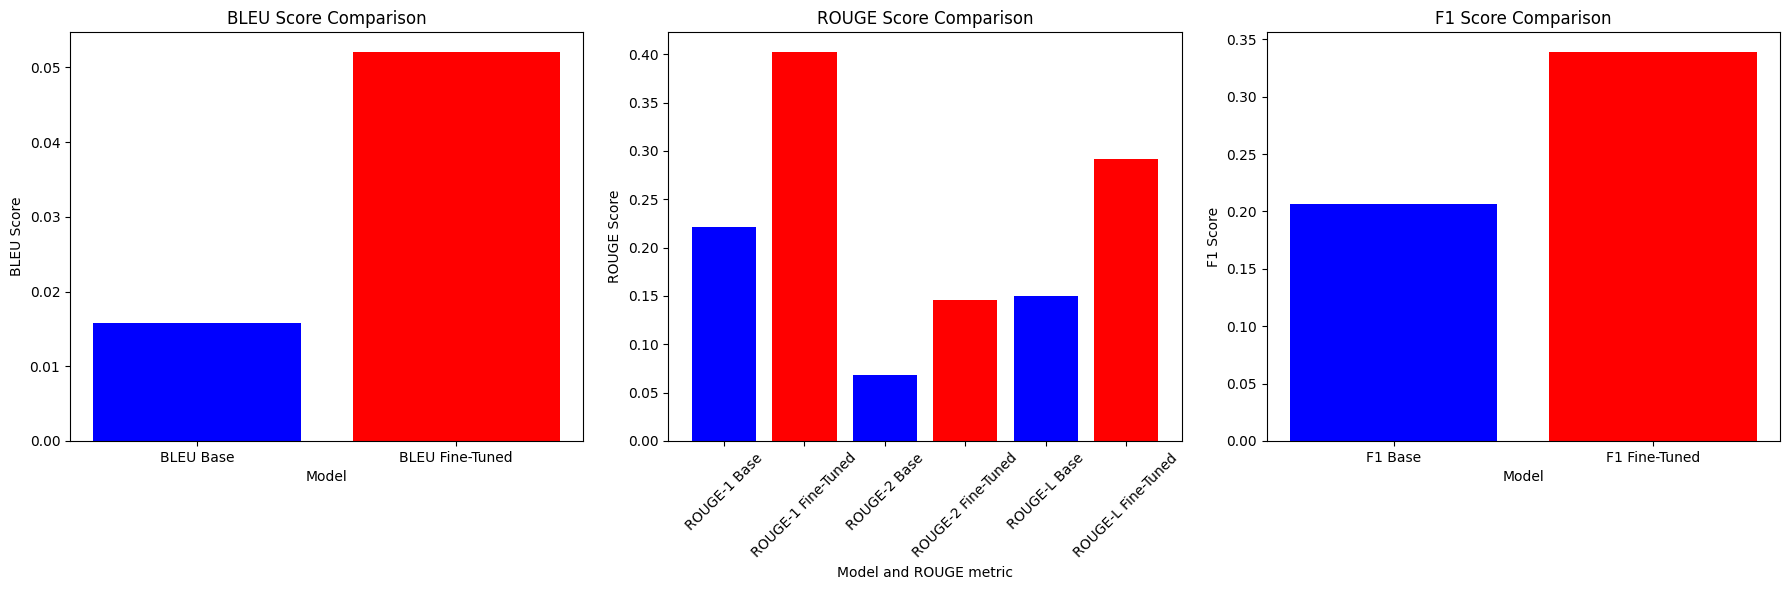

In [ ]:
import matplotlib.pyplot as plt

# Données pour les scores
labels_bleu = ["BLEU Base", "BLEU Fine-Tuned"]
values_bleu = [avg_bleu_base, avg_bleu_fine_tuned]

labels_rouge = ["ROUGE-1 Base", "ROUGE-1 Fine-Tuned", "ROUGE-2 Base", "ROUGE-2 Fine-Tuned", "ROUGE-L Base", "ROUGE-L Fine-Tuned"]
values_rouge = [avg_rouge1_base, avg_rouge1_fine_tuned, avg_rouge2_base, avg_rouge2_fine_tuned, avg_rougeL_base, avg_rougeL_fine_tuned]

labels_f1 = ["F1 Base", "F1 Fine-Tuned"]
values_f1 = [f1_base, f1_fine_tuned]

# Créer une figure avec 3 sous-graphiques (subplots)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Histogramme BLEU
axs[0].bar(labels_bleu, values_bleu, color=['blue', 'red'])
axs[0].set_xlabel('Model')
axs[0].set_ylabel('BLEU Score')
axs[0].set_title('BLEU Score Comparison')

# Histogramme ROUGE
axs[1].bar(labels_rouge, values_rouge, color=['blue', 'red', 'blue', 'red', 'blue', 'red'])
axs[1].set_xlabel('Model and ROUGE metric')
axs[1].set_ylabel('ROUGE Score')
axs[1].set_title('ROUGE Score Comparison')
axs[1].tick_params(axis='x', rotation=45)

# Histogramme F1
axs[2].bar(labels_f1, values_f1, color=['blue', 'red'])
axs[2].set_xlabel('Model')
axs[2].set_ylabel('F1 Score')
axs[2].set_title('F1 Score Comparison')

# Ajuster l'espacement entre les graphiques
plt.tight_layout()

# Afficher la fenêtre avec les 3 histogrammes
plt.show()
